A notebook for finetuning Stable Diffusion using LORA.

Tested with [Stable Diffusion v1-5](https://huggingface.co/runwayml/stable-diffusion-v1-5).

Notebook developed by [pedrogengo](https://github.com/
pedrogengo).

In [1]:
%mkdir output_directory
!ls -la

total 5064
drwxr-xr-x  6 itwastony  staff      192 Sep  4 23:51 .
drwxr-xr-x  7 itwastony  staff      224 Sep  4 23:35 ..
-rw-r--r--@ 1 itwastony  staff     6148 Sep  4 23:47 .DS_Store
-rw-r--r--@ 1 itwastony  staff  2580613 Sep  4 23:48 dreambooth_lora_finetune.ipynb
drwxr-xr-x  2 itwastony  staff       64 Sep  4 23:51 output_directory
drwxr-xr-x@ 9 itwastony  staff      288 Sep  4 23:47 pepe_images


# SETUP

In [4]:
# !git clone https://github.com/cloneofsimo/lora.git && sed -i 's/functools.cache/functools.lru_cache(maxsize=None)/g' /content/lora/lora_diffusion/xformers_utils.py && pip install /content/lora
!pip install accelerate bitsandbytes


  Obtaining dependency information for accelerate from https://files.pythonhosted.org/packages/4d/a7/05c67003d659a0035f2b3a8cf389c1d9645865aee84a73ce99ddab16682f/accelerate-0.22.0-py3-none-any.whl.metadata
  Obtaining dependency information for bitsandbytes from https://files.pythonhosted.org/packages/1e/2c/af22cd797fc368a9f098ed03015730e6568b884fe67f9940793d944a4b7b/bitsandbytes-0.41.1-py3-none-any.whl.metadata
  Obtaining dependency information for numpy>=1.17 from https://files.pythonhosted.org/packages/86/a1/b8ef999c32f26a97b5f714887e21f96c12ae99a38583a0a96e65283ac0a1/numpy-1.25.2-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for pyyaml from https://files.pythonhosted.org/packages/28/09/55f715ddbf95a054b764b547f617e22f1d5e45d83905660e9a088078fe67/PyYAML-6.0.1-cp311-cp311-macosx_11_0_arm64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 MB 1.4 MB/s eta 0:00:0000:0100:01m
  Obtaining dependency information for filelock from https:/

# TRAINING

Важно исправить параметр logging_dir в Accelerate. Название параметра устарело, теперь он называется project_dir.

In [5]:
import os
import shutil
from tqdm import tqdm

import matplotlib.pyplot as plt


PRETRAINED_MODEL="runwayml/stable-diffusion-v1-5" #@param{type: 'string'}
PROMPT="photo of iyt Pepe The Frog" #@param{type: 'string'}

OUTPUT_DIR="output_directory" #@param{type: 'string'}
IMAGES_FOLDER_OPTIONAL="pepe_images" #@param{type: 'string'}

RESOLUTION="512" #@param ["512", "576", "640", "704", "768", "832", "896", "960", "1024"]
RESOLUTION=int(RESOLUTION)

if PRETRAINED_MODEL == "":
  print('[1;31mYou should define the pretrained model.')

else:
  if IMAGES_FOLDER_OPTIONAL=="":
    INSTANCE_DIR = "/content/data_example"
    if not os.path.exists(str(INSTANCE_DIR)):
      %mkdir -p "$INSTANCE_DIR"
    uploaded = files.upload()
    for filename in tqdm(uploaded.keys(), bar_format='  |{bar:15}| {n_fmt}/{total_fmt} Uploaded'):
        shutil.move(filename, INSTANCE_DIR)
  else:
    INSTANCE_DIR = IMAGES_FOLDER_OPTIONAL

  if OUTPUT_DIR == "":
    OUTPUT_DIR = "/content/output"
  if not os.path.exists(str(OUTPUT_DIR)):
    %mkdir -p "$OUTPUT_DIR"

In [6]:
# Исправить здесь logging_dir

STEPS = 1000 #@param {type:"slider", min:0, max:10000, step:10}
BATCH_SIZE = 1 #@param {type:"slider", min:0, max:128, step:1}
FP_16 = True #@param {type:"boolean"}

#@markdown ----
#@markdown UNET PARAMS
LEARNING_RATE = 1e-4 #@param {type:"number"}

#@markdown ----
TRAIN_TEXT_ENCODER = True #@param {type:"boolean"}
#@markdown TEXT ENCODER PARAMS
LEARNING_RATE_TEXT_ENCODER = 5e-5 #@param {type:"number"}

NEW_LEARNING_RATE = LEARNING_RATE / BATCH_SIZE
NEW_LEARNING_RATE_TEXT_ENCODER = LEARNING_RATE_TEXT_ENCODER / BATCH_SIZE

if FP_16:
  fp_16_arg = "fp16"
else:
  fp_16_arg = "no"

if TRAIN_TEXT_ENCODER:
  command = (f'accelerate launch lora/training_scripts/train_lora_dreambooth.py '
             f'--pretrained_model_name_or_path="{PRETRAINED_MODEL}" '
             f'--instance_data_dir="{INSTANCE_DIR}" '
             f'--output_dir="{OUTPUT_DIR}" '
             f'--instance_prompt="{PROMPT}" '
             f'--resolution=512 '
             f'--use_8bit_adam '
             f'--mixed_precision="{fp_16_arg}" '
             f'--train_batch_size=1 '
             f'--gradient_accumulation_steps=1 '
             f'--learning_rate={NEW_LEARNING_RATE} '
             f'--lr_scheduler="constant" '
             f'--lr_warmup_steps=0 '
             f'--max_train_steps={STEPS} '
             f'--train_text_encoder '
             f'--lora_rank=16 '
             f'--learning_rate_text={NEW_LEARNING_RATE_TEXT_ENCODER}')
else:
  command = (f'accelerate launch lora/training_scripts/train_lora_dreambooth.py '
             f'--pretrained_model_name_or_path="{PRETRAINED_MODEL}" '
             f'--instance_data_dir="{INSTANCE_DIR}" '
             f'--output_dir="{OUTPUT_DIR}" '
             f'--instance_prompt="{PROMPT}" '
             f'--resolution=512 '
             f'--use_8bit_adam '
             f'--mixed_precision="{fp_16_arg}" '
             f'--train_batch_size=1 '
             f'--gradient_accumulation_steps=1 '
             f'--learning_rate={NEW_LEARNING_RATE} '
             f'--lr_scheduler="constant" '
             f'--lr_warmup_steps=0 '
             f'--lora_rank=16 '
             f'--max_train_steps={STEPS} '
             f'--learning_rate_text={NEW_LEARNING_RATE_TEXT_ENCODER}')

!rm -rf $INSTANCE_DIR/.ipynb_checkpoints
!{command}

2023-09-04 19:22:10.799036: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
The following values were not passed to `accelerate launch` and had defaults used instead:
	`--num_processes` was set to a value of `1`
	`--num_machines` was set to a value of `1`
	`--mixed_precision` was set to a value of `'no'`
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
2023-09-04 19:22:16.582183: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Before training: Unet First Layer lora up tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
Before training: Unet First Layer lora down tensor([[-5.7096e-02, -2.4407

# INFERENCE

In [7]:
#@title LOADING MODEL AND MONKEY PATCHING IT
# Исрав
import torch
from lora_diffusion import monkeypatch_or_replace_lora, tune_lora_scale
from diffusers import StableDiffusionPipeline


pipe = StableDiffusionPipeline.from_pretrained(PRETRAINED_MODEL, torch_dtype=torch.float16).to("cuda")
monkeypatch_or_replace_lora(pipe.unet, torch.load(os.path.join(OUTPUT_DIR, "lora_weight.pt")))
monkeypatch_or_replace_lora(pipe.text_encoder, torch.load(os.path.join(OUTPUT_DIR, "lora_weight.text_encoder.pt")), target_replace_module=["CLIPAttention"])

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [8]:
pipe.safety_checker = None

  0%|          | 0/100 [00:00<?, ?it/s]

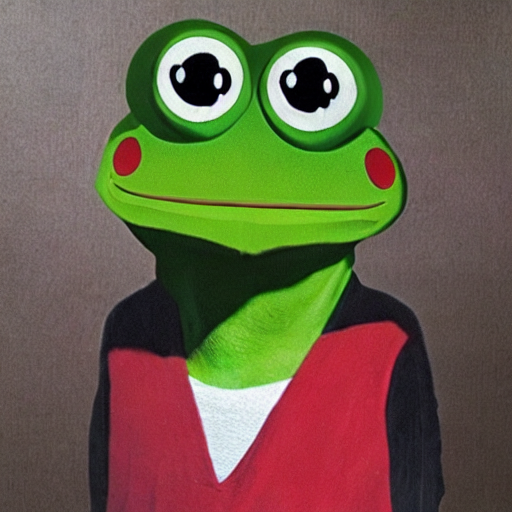

In [9]:
INFERENCE_PROMPT = 'photo of iyt Pepe The Frog' #@param {type:"string"}
LORA_SCALE_UNET = 0.1 #@param {type:"number"}
LORA_SCALE_TEXT_ENCODER = 0.1 #@param {type:"number"}
GUIDANCE = 4.4 #@param {type:"slider", min:0, max:15, step:0.2}†
tune_lora_scale(pipe.unet, LORA_SCALE_UNET)

if TRAIN_TEXT_ENCODER:
  tune_lora_scale(pipe.text_encoder, LORA_SCALE_TEXT_ENCODER)

image = pipe(INFERENCE_PROMPT, num_inference_steps=100, guidance_scale=GUIDANCE).images[0]
image

# GridSearch hyperparameters

В этом разделе хотел перебрать максимальное количество гиперпараметров, которые могли бы улучшить результат генерации изображения с максимальным сохранением детализации. Также в качестве идеи хотел посмотреть в токенайзер языковой модели, и найти там редкий токен для связки его с изображением для улучшения генерации.

## number of inference steps

In [36]:
def get_image(num_steps):
    tune_lora_scale(pipe.unet, LORA_SCALE_UNET)

    if TRAIN_TEXT_ENCODER:
        tune_lora_scale(pipe.text_encoder, LORA_SCALE_TEXT_ENCODER)

    image = pipe(INFERENCE_PROMPT, num_inference_steps=num_steps, guidance_scale=GUIDANCE).images[0]

    plt.imshow(image)

    return image


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/350 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/450 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/650 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/850 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

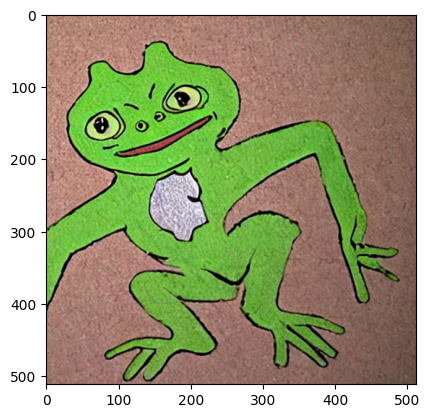

In [37]:
MIN_STEPS = 50
MAX_STEPS = 1000
GRID_STEP = 50

N_OF_IMAGES = MAX_STEPS // GRID_STEP

num_inference_steps = range(MIN_STEPS, MAX_STEPS, GRID_STEP)
inference_steps_grid = {}

for steps in num_inference_steps:
    image = get_image(steps)

    inference_steps_grid[steps] = image


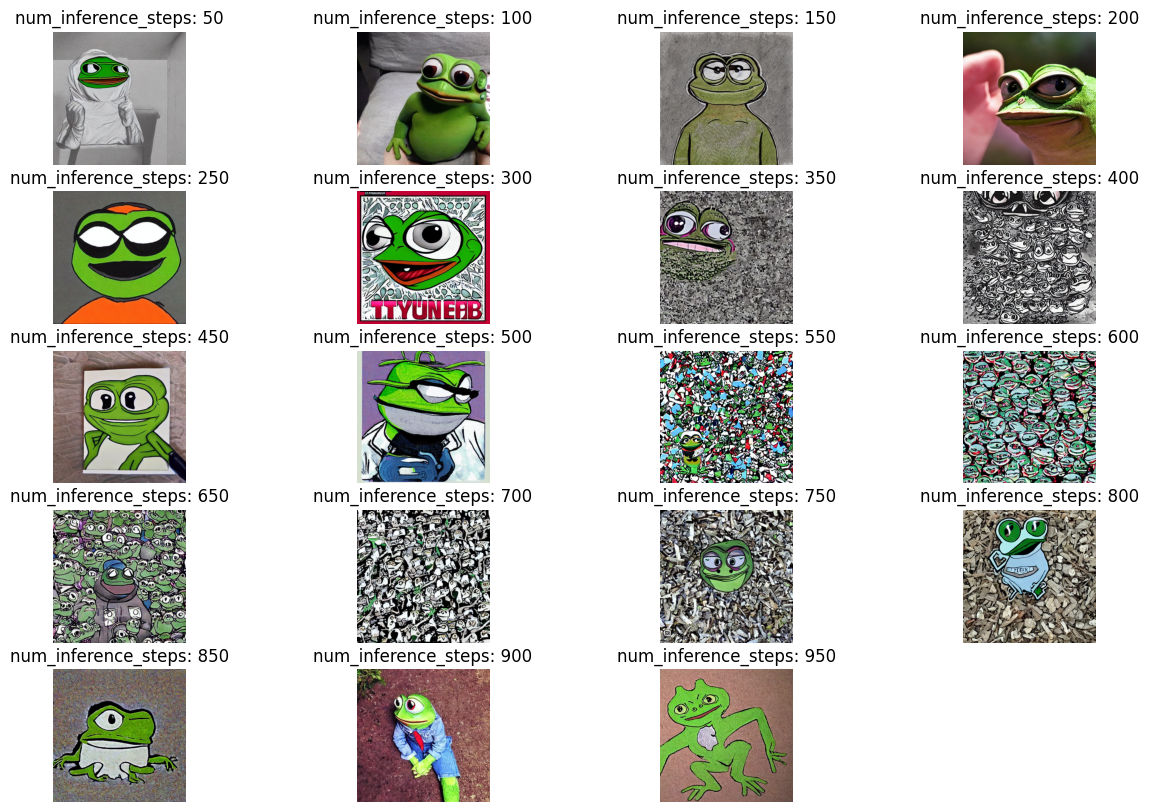

In [41]:
fig = plt.figure(figsize=(15, 10))

rows = 5
columns = 4

for idx, (steps, image) in enumerate(inference_steps_grid.items()):
    nof_image = idx + 1

    fig.add_subplot(rows, columns, nof_image)

    plt.imshow(image)
    plt.axis('off')
    plt.title(f"num_inference_steps: {steps}")

